# Regression analysis

In [1]:
%matplotlib inline

import geopandas as gpd
from geopandas import GeoDataFrame

import pandas as pd
import contextily as ctx
import gtfs_kit as gk
import shapely
import rtree
import xarray as xr
from shapely.geometry import mapping
from shapely.ops import unary_union
import h3
import base64
import urllib
import tempfile
import networkx as nx
from csv import DictReader
from itertools import groupby
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
combined = gpd.read_parquet("combined_census.parquet")

## Helping functions

In [3]:
def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16,12), colormap='YlGnBu', basemap=None, ax=None):  
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    df.plot.scatter(ax=ax, x=x, y=y, c="white", title=metric_col
                    , edgecolors='none', marker=marker, alpha=alpha, figsize=figsize);
    if basemap:
        ctx.add_basemap(ax=ax, crs=basemap)

    plt.xticks([], []); plt.yticks([], [])
    return ax
    

In [4]:
import scipy
import scipy.cluster.hierarchy as sch
import numpy as np

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]


# Correaltion (sanity check)

In [5]:
normalized_cols = ['Average Commute to Work (In Min)',"over_16_puplictransportation",
                "over_16_worked_home",
                "over_16_non_polution_transport",
                "over_16_non_public_transport",
                "comute_time_less_30min",
                "comute_time_more_30min",
                 'male_population',
               'total_population_white', 'total_population_black',
               'total_population_two_ormore_races', 'total_population_asian',"female_population",
                'population_over_25_no_highschool',
               'population_over_25_highschool', 'population_over_25_bachelor',
               'population_over_25_master', 'households_0_to_50,000',
               'households_over_50,000']

<AxesSubplot:>

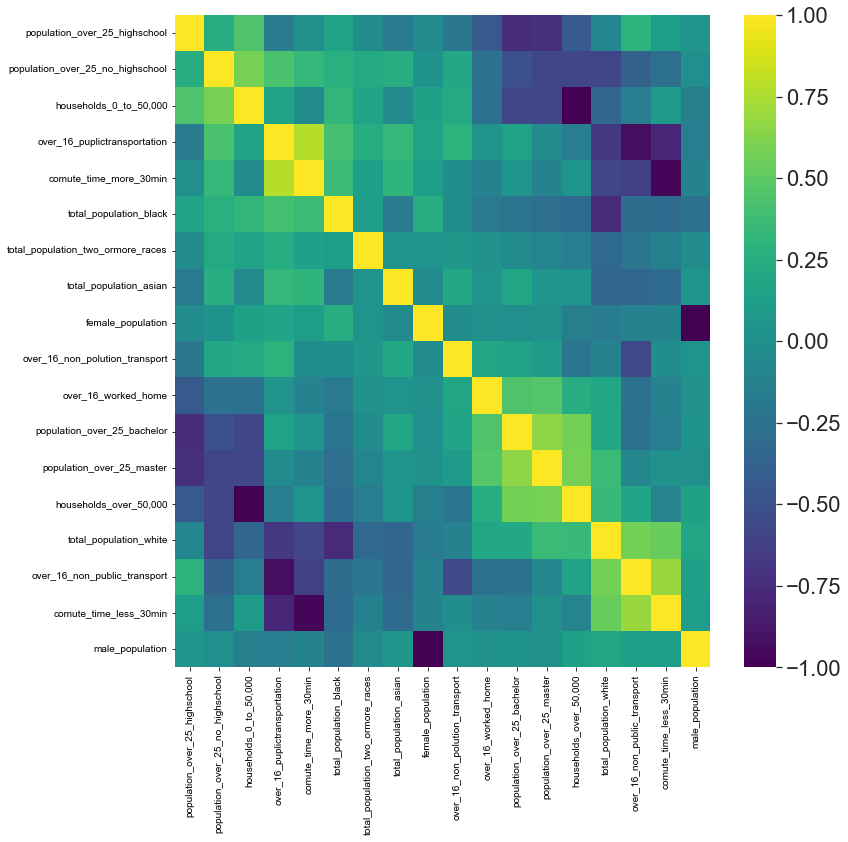

In [6]:
fig, ax = plt.subplots(1, figsize=(12,12))
sns.set(font_scale=2)

sns.heatmap(cluster_corr(combined[normalized_cols].corr()), cmap="viridis")


In [7]:
combined = combined.to_crs("EPSG:4326")

## Loading the accessibility data

In [8]:
hex_df = pd.read_csv("smoothed_accessibility_score.csv")

In [9]:
hex_df.head()

,Unnamed: 0,hex9,accessibility_score,lat,lon
0,0,892a1000003ffff,0.505531,40.858416,-73.781928
1,1,892a1000007ffff,0.616906,40.855826,-73.779693
2,2,892a100000bffff,0.505531,40.858308,-73.786214
3,3,892a100000fffff,0.616906,40.855718,-73.783978
4,4,892a100001bffff,0.393809,40.861007,-73.784163


# Spatial analysis for the entire county

In [10]:
gdf = combined.loc[combined.COUNTYFP.isin(["081", "005", "047", "085", "061", "103", "059", "087", "119", "079", "071","027"])].copy()
gdf = gdf.to_crs("EPSG:4326")

METRIC_COL = "over_16_puplictransportation"
# Drop row with nan METRIC
gdf = gdf.loc[~gdf[METRIC_COL].isna()]

In [11]:
sgdf = gpd.GeoDataFrame(hex_df, geometry=gpd.points_from_xy(hex_df.lon, hex_df.lat), crs=gdf.crs)

In [12]:
accessibility_metric = "accessibility_score"
gdf = sgdf[[accessibility_metric, "geometry"]].sjoin(gdf, how="right", predicate='intersects').drop(columns=["index_left"]).fillna(0)

In [13]:
gdf.GEOID.nunique(), gdf.shape

(3390, (15928, 110))

In [14]:
feature_col = [accessibility_metric, 'Average Commute to Work (In Min)',
       'over_16_puplictransportation', 'over_16_worked_home',
       'over_16_non_polution_transport', 'over_16_non_public_transport',
       'comute_time_less_30min', 'comute_time_more_30min', 'male_population',
       'total_population_white', 'total_population_black',
       'total_population_two_ormore_races', 'total_population_asian',
       'female_population', 'population_over_25_no_highschool',
       'population_over_25_highschool', 'population_over_25_bachelor',
       'population_over_25_master', 'households_0_to_50,000',
       'households_over_50,000']
target_col = METRIC_COL
feature_col = np.array([col for col in feature_col if col not in [target_col]])

In [15]:
gdf['Average Commute to Work (In Min)'] = gdf['Average Commute to Work (In Min)'].fillna("0").astype(float)

In [16]:
gdf = gdf.groupby("GEOID").agg("max").reset_index().merge(gdf[["GEOID", "geometry"]].drop_duplicates(), on="GEOID")

/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/pandas/core/apply.py:577: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  return f(*args, **kwargs)


In [17]:
regression_df = gdf[feature_col.tolist()+[METRIC_COL]].copy()

In [18]:
# Log transform the accessibility scores
regression_df[f"log_{accessibility_metric}"] = np.log(regression_df[accessibility_metric]+1)

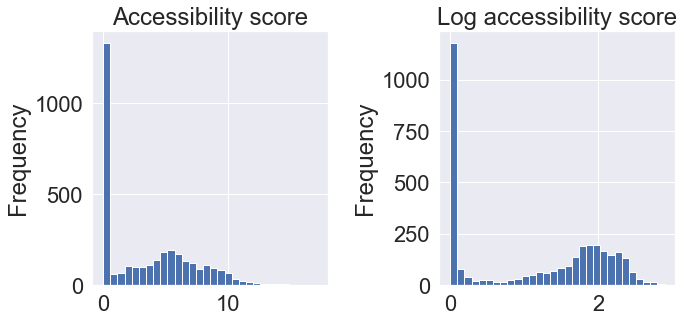

In [19]:
fig, axs = plt.subplots(1,2, figsize = (10,5))
axs[0] = regression_df[accessibility_metric].plot.hist(bins=30, ax=axs[0])
axs[0].set_title("Accessibility score")

axs[1] = regression_df[f"log_{accessibility_metric}"].plot.hist(bins=30, ax=axs[1])
axs[1].set_title("Log accessibility score")
plt.tight_layout()
plt.savefig("figs/accesibillity_scores.png")
plt.show()


In [20]:
feature_col = np.append(feature_col,f"log_{accessibility_metric}")

In [21]:
kf = KFold(n_splits=5)

X = regression_df[feature_col]
y = regression_df[target_col].values

In [22]:
preds = np.zeros(len(y))
coefs = np.zeros(len(X.columns))
for train_index, test_index in kf.split(regression_df):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    scaler = scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    reg = Ridge().fit(X_train_scaled, y_train)
    coefs += reg.coef_
    preds[test_index] = reg.predict(X_test_scaled)

coefs /= 5

MSE:0.007753901236317313, Baseline MSE: 0.23720404905305492
R^2 (coefficient of determination) regression score function.: 0.9989314463461512, Baseline: 0.0


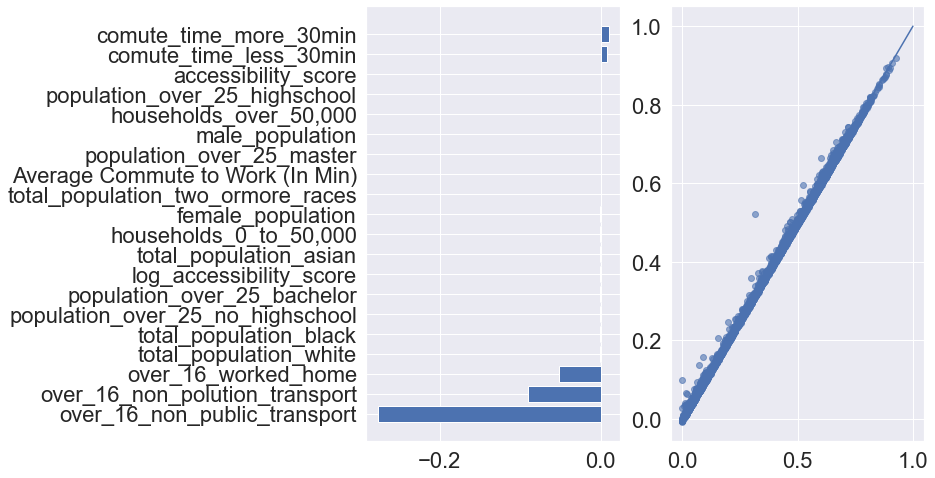

In [23]:
baseline_preds = [np.array(y).mean()]*len(y)
baseline_mse, baseline_r2 = mean_squared_error(y, baseline_preds, squared=False), r2_score(y, baseline_preds)

mse, r2 = mean_squared_error(y, preds, squared=False), r2_score(y, preds)

print(f"MSE:{mse}, Baseline MSE: {baseline_mse}")
print(f"R^2 (coefficient of determination) regression score function.: {r2}, Baseline: {baseline_r2}")

fig, ax = plt.subplots(1,2, figsize=(10,8))
idx = np.argsort(coefs)
ax[0].barh(feature_col[idx],coefs[idx])

ax[1].scatter(y, preds, alpha=0.6)
ax[1].plot([i for i in range(2)])
plt.show()

In [24]:
non_feature_cols = ['over_16_non_public_transport', 'over_16_non_polution_transport']
feature_col =  np.array([col for col in feature_col if col not in non_feature_cols])

kf = KFold(n_splits=5)

X = regression_df[feature_col].values
y = regression_df[target_col].values
preds = np.zeros(len(y))
coefs = np.zeros(len(feature_col))
for train_index, test_index in kf.split(regression_df):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    scaler = scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    reg = Ridge().fit(X_train_scaled, y_train)
    coefs += reg.coef_
    preds[test_index] = reg.predict(X_test_scaled)

coefs /= 5


MSE:0.1157698129461985, Baseline MSE: 0.23720404905305492
R^2 (coefficient of determination) regression score function.: 0.7617974167900157, Baseline: 0.0


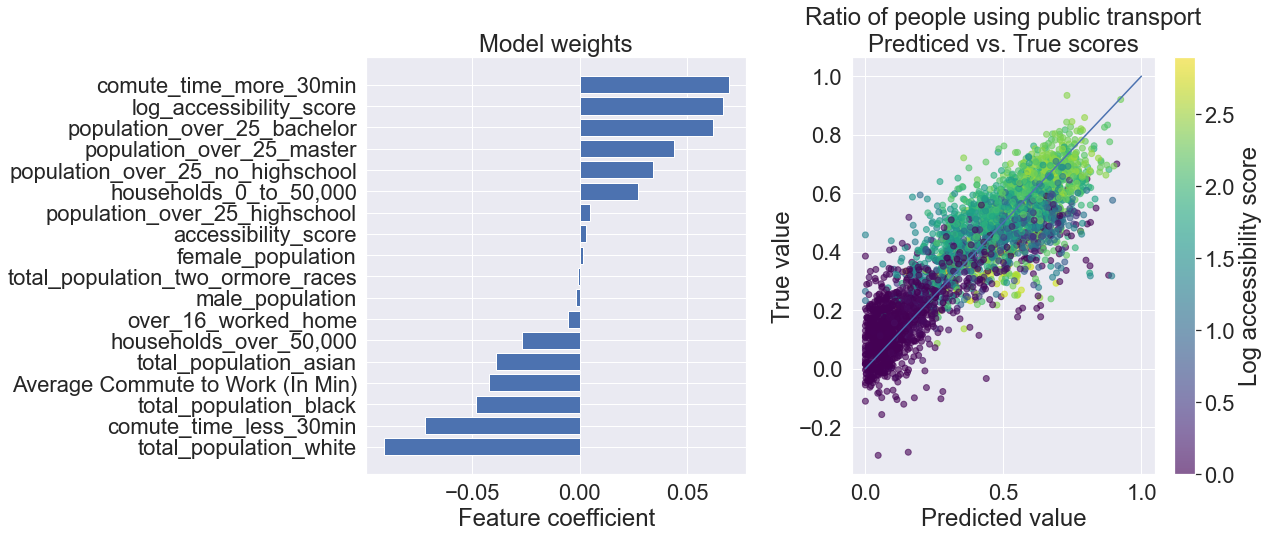

In [25]:
baseline_preds = [np.array(y).mean()]*len(y)
baseline_mse, baseline_r2 = mean_squared_error(y, baseline_preds, squared=False), r2_score(y, baseline_preds)

mse, r2 = mean_squared_error(y, preds, squared=False), r2_score(y, preds)

print(f"MSE:{mse}, Baseline MSE: {baseline_mse}")
print(f"R^2 (coefficient of determination) regression score function.: {r2}, Baseline: {baseline_r2}")


fig, ax = plt.subplots(1,2, figsize=(18,8))
idx = np.argsort(coefs)

ax[0].set_title("Model weights")
ax[0].barh(feature_col[idx],coefs[idx])
ax[0].set_xlabel("Feature coefficient")

points = ax[1].scatter(y, preds, alpha=0.6, c = regression_df[f"log_{accessibility_metric}"], cmap="viridis")
ax[1].set_title("Ratio of people using public transport\nPredticed vs. True scores")
ax[1].plot([x for x in range(2)])
ax[1].set_xlabel("Predicted value")
ax[1].set_ylabel("True value")

plt.colorbar(points,ax=ax[1], label="Log accessibility score")
plt.tight_layout()
plt.savefig("figs/state_modelsum_manyfeatures.png")
plt.show()


In [26]:
non_feature_cols =['over_16_non_public_transport', 'over_16_non_polution_transport', 'comute_time_less_30min', 'Average Commute to Work (In Min)', 'over_16_worked_home', 'comute_time_more_30min']
feature_col =  np.array([col for col in feature_col if col not in non_feature_cols])

kf = KFold(n_splits=5)

X = regression_df[feature_col].values
y = regression_df[target_col].values
preds = np.zeros(len(y))
coefs = np.zeros(len(feature_col))
for train_index, test_index in kf.split(regression_df):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    scaler = scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    reg = Ridge().fit(X_train_scaled, y_train)
    coefs += reg.coef_
    preds[test_index] = reg.predict(X_test_scaled)

coefs /= 5


MSE:0.14513208288565008, Baseline MSE: 0.23720404905305492
R^2 (coefficient of determination) regression score function.: 0.6256458430382237, Baseline: 0.0


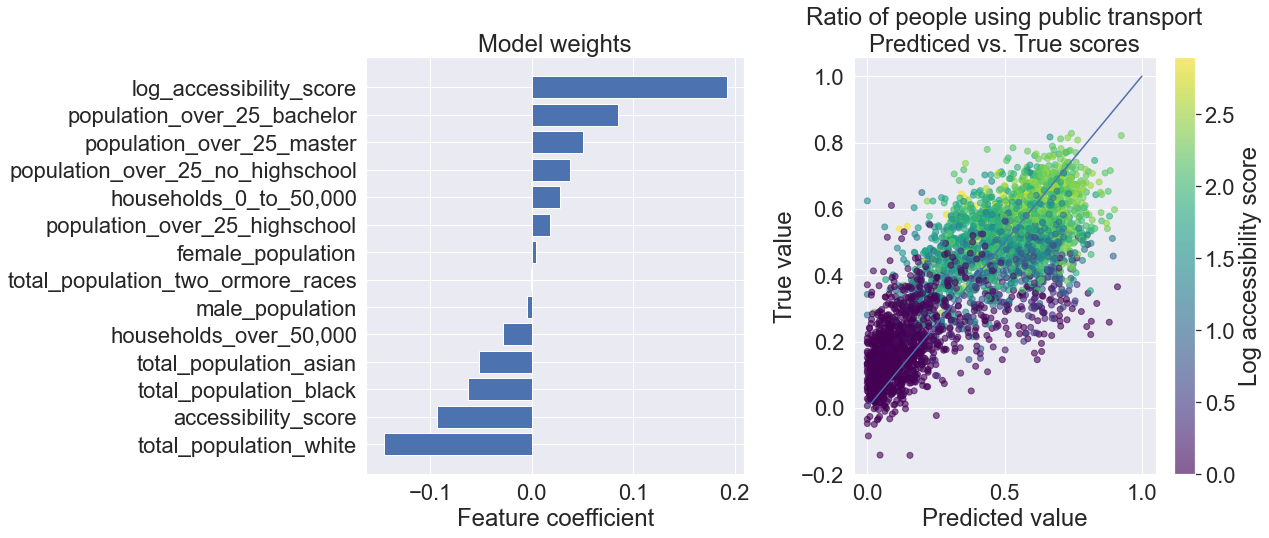

In [27]:
baseline_preds = [np.array(y).mean()]*len(y)
baseline_mse, baseline_r2 = mean_squared_error(y, baseline_preds, squared=False), r2_score(y, baseline_preds)

mse, r2 = mean_squared_error(y, preds, squared=False), r2_score(y, preds)

print(f"MSE:{mse}, Baseline MSE: {baseline_mse}")
print(f"R^2 (coefficient of determination) regression score function.: {r2}, Baseline: {baseline_r2}")


fig, ax = plt.subplots(1,2, figsize=(18,8))
idx = np.argsort(coefs)

ax[0].set_title("Model weights")
ax[0].barh(feature_col[idx],coefs[idx])
ax[0].set_xlabel("Feature coefficient")

points = ax[1].scatter(y, preds, alpha=0.6, c = regression_df[f"log_{accessibility_metric}"], cmap="viridis")
ax[1].set_title("Ratio of people using public transport\nPredticed vs. True scores")
ax[1].plot([x for x in range(2)])
ax[1].set_xlabel("Predicted value")
ax[1].set_ylabel("True value")

plt.colorbar(points,ax=ax[1], label="Log accessibility score")
plt.tight_layout()
plt.savefig("figs/state_modelsum_fewfeatures.png")
plt.show()


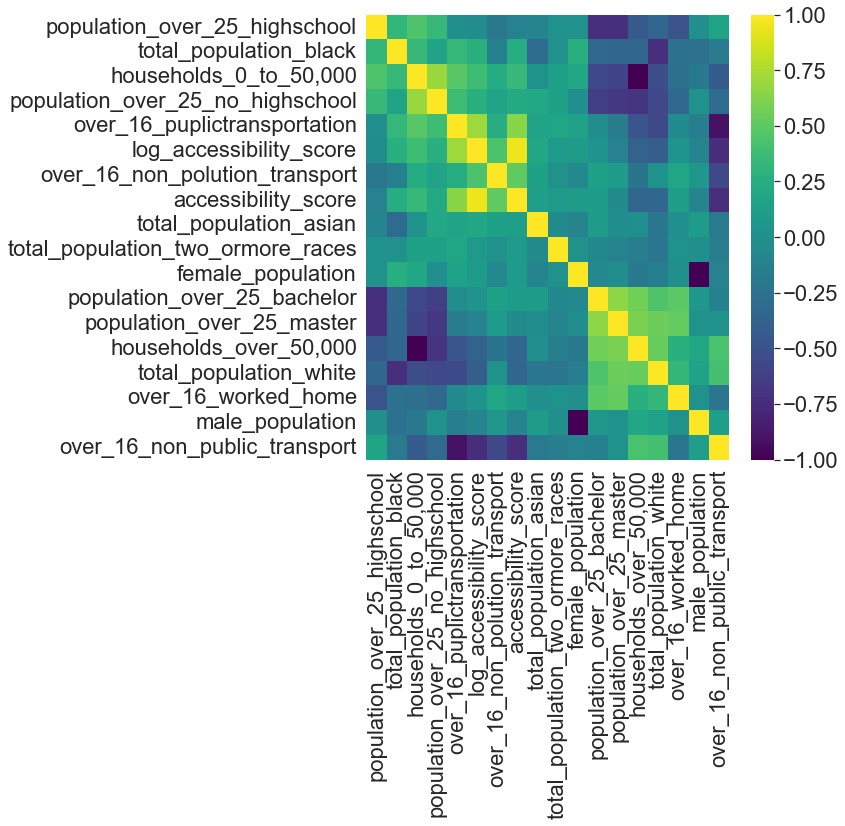

In [28]:
fig, ax = plt.subplots(1, figsize=(12,12))

sns.heatmap(cluster_corr(regression_df[feature_col.tolist() + [target_col, 'over_16_non_public_transport', 'over_16_non_polution_transport', 'over_16_worked_home',]].corr()), cmap="viridis")
plt.tight_layout()
plt.savefig("figs/state_correlations.png")

### Visualizing the results on maps

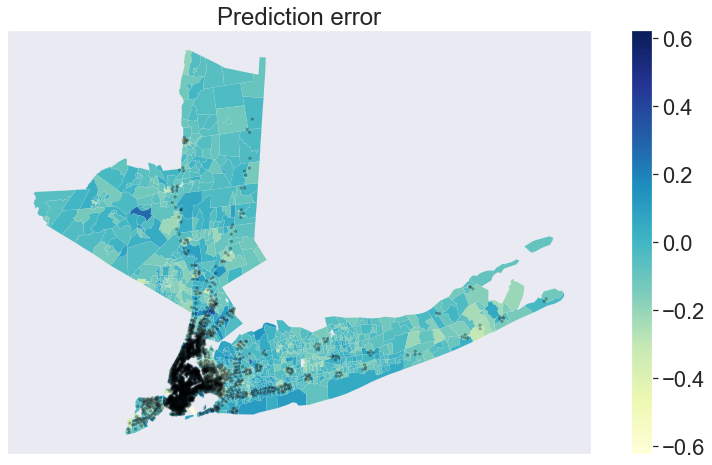

In [29]:
# Visualize Population Density per Census Tract
f, ax = plt.subplots(figsize=(12,7))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
gdf["Prediction_diff"] = y - preds
scatter_df = gdf.sjoin(sgdf, how="left").groupby("GEOID").agg("mean")

ax = gdf.plot(column="Prediction_diff",cmap='YlGnBu',alpha=1,linewidth=0.05,ax=ax, legend=True)
ax = scatter_df.plot.scatter(ax=ax, y="lat", x="lon", color="black", alpha=.3, edgecolors='none', s=10)


plt.title('Prediction error')
plt.tight_layout()
plt.savefig("figs/state_map_res.png")
plt.show()

In [30]:
gdf.to_parquet("county_gdf.parquet")

/var/folders/bx/2b_70g054qg3qt5jhnw30xv40000gn/T/ipykernel_74084/1931467242.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  gdf.to_parquet("county_gdf.parquet")


# Spatial analysis for the city

In [31]:
gdf = combined.loc[combined.COUNTYFP.isin(["081", "005", "047", "085", "061"])].copy()
gdf = gdf.to_crs("EPSG:4326")

METRIC_COL = "over_16_puplictransportation"
# Drop row with nan METRIC
gdf = gdf.loc[~gdf[METRIC_COL].isna()]

sgdf = gpd.GeoDataFrame(hex_df, geometry=gpd.points_from_xy(hex_df.lon, hex_df.lat), crs=gdf.crs)

accessibility_metric = "accessibility_score"
gdf = sgdf[[accessibility_metric, "geometry"]].sjoin(gdf, how="right", predicate='intersects').drop(columns=["index_left"]).fillna(0)

gdf.GEOID.nunique(), gdf.shape

feature_col = [accessibility_metric, 'Average Commute to Work (In Min)',
       'over_16_puplictransportation', 'over_16_worked_home',
       'over_16_non_polution_transport', 'over_16_non_public_transport',
       'comute_time_less_30min', 'comute_time_more_30min', 'male_population',
       'total_population_white', 'total_population_black',
       'total_population_two_ormore_races', 'total_population_asian',
       'female_population', 'population_over_25_no_highschool',
       'population_over_25_highschool', 'population_over_25_bachelor',
       'population_over_25_master', 'households_0_to_50,000',
       'households_over_50,000']
target_col = METRIC_COL
feature_col = np.array([col for col in feature_col if col not in [target_col]])

gdf['Average Commute to Work (In Min)'] = gdf['Average Commute to Work (In Min)'].fillna("0").astype(float)

gdf = gdf.groupby("GEOID").agg("max").reset_index().merge(gdf[["GEOID", "geometry"]].drop_duplicates(), on="GEOID")

/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/pandas/core/apply.py:577: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  return f(*args, **kwargs)


In [32]:
regression_df = gdf[feature_col.tolist()+[target_col]].copy()


In [33]:
# Log transform the accessibility scores
regression_df[f"log_{accessibility_metric}"] = np.log(regression_df[accessibility_metric]+1)

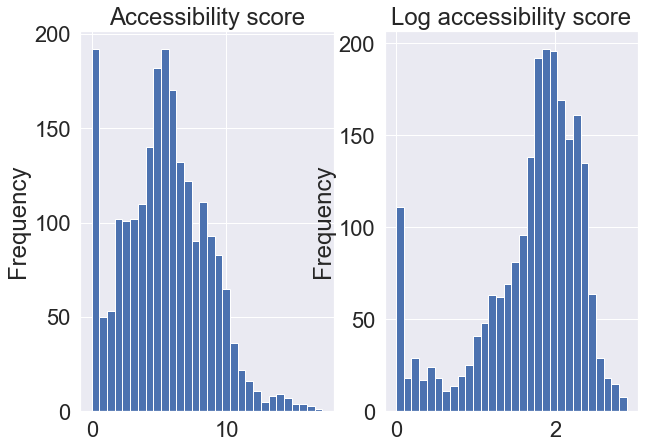

In [34]:
fig, axs = plt.subplots(1,2, figsize = (10,7))
axs[0] = regression_df[accessibility_metric].plot.hist(bins=30, ax=axs[0])
axs[0].set_title("Accessibility score")

axs[1] = regression_df[f"log_{accessibility_metric}"].plot.hist(bins=30, ax=axs[1])
axs[1].set_title("Log accessibility score")
plt.show()

In [35]:
feature_col = np.append(feature_col,f"log_{accessibility_metric}")

In [36]:
kf = KFold(n_splits=5)

X = regression_df[feature_col]
y = regression_df[target_col].values

In [37]:
preds = np.zeros(len(y))
coefs = np.zeros(len(X.columns))
for train_index, test_index in kf.split(regression_df):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    scaler = scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    reg = Ridge().fit(X_train_scaled, y_train)
    coefs += reg.coef_
    preds[test_index] = reg.predict(X_test_scaled)

coefs /= 5

MSE:0.008077339674409668, Baseline MSE: 0.16125426622652775
R^2 (coefficient of determination) regression score function.: 0.9974909214000458, Baseline: 0.0


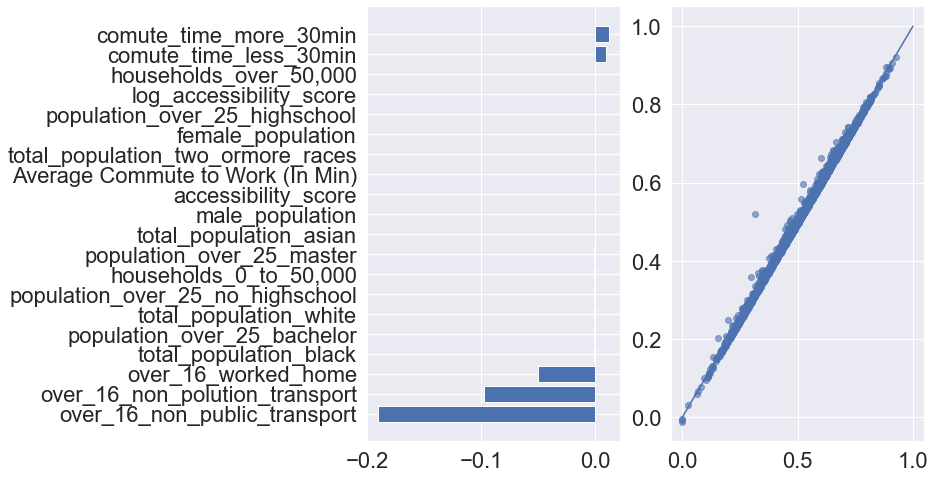

In [38]:
baseline_preds = [np.array(y).mean()]*len(y)
baseline_mse, baseline_r2 = mean_squared_error(y, baseline_preds, squared=False), r2_score(y, baseline_preds)

mse, r2 = mean_squared_error(y, preds, squared=False), r2_score(y, preds)

print(f"MSE:{mse}, Baseline MSE: {baseline_mse}")
print(f"R^2 (coefficient of determination) regression score function.: {r2}, Baseline: {baseline_r2}")

fig, ax = plt.subplots(1,2, figsize=(10,8))
idx = np.argsort(coefs)
ax[0].barh(feature_col[idx],coefs[idx])

ax[1].scatter(y, preds, alpha=0.6)
ax[1].plot([i for i in range(2)])
plt.show()

In [39]:
non_feature_cols = ['over_16_non_public_transport', 'over_16_non_polution_transport']
feature_col =  np.array([col for col in feature_col if col not in non_feature_cols])

kf = KFold(n_splits=5)

X = regression_df[feature_col].values
y = regression_df[target_col].values
preds = np.zeros(len(y))
coefs = np.zeros(len(feature_col))
for train_index, test_index in kf.split(regression_df):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    scaler = scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    reg = Ridge().fit(X_train_scaled, y_train)
    coefs += reg.coef_
    preds[test_index] = reg.predict(X_test_scaled)

coefs /= 5


MSE:0.11648039151485146, Baseline MSE: 0.16125426622652775
R^2 (coefficient of determination) regression score function.: 0.47822506014004307, Baseline: 0.0


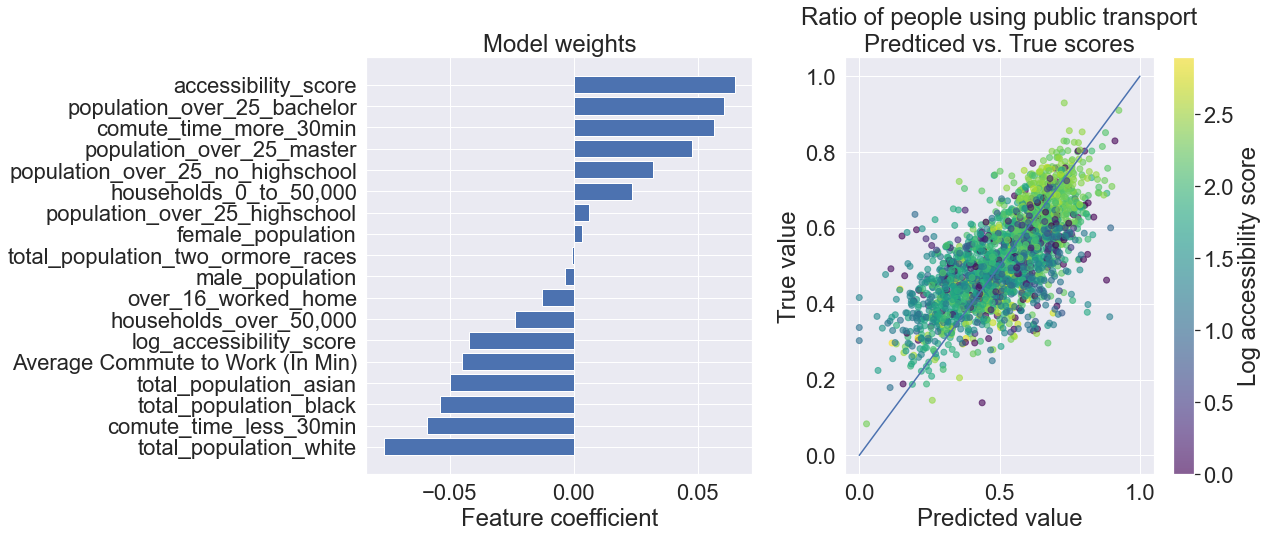

In [40]:
baseline_preds = [np.array(y).mean()]*len(y)
baseline_mse, baseline_r2 = mean_squared_error(y, baseline_preds, squared=False), r2_score(y, baseline_preds)

mse, r2 = mean_squared_error(y, preds, squared=False), r2_score(y, preds)

print(f"MSE:{mse}, Baseline MSE: {baseline_mse}")
print(f"R^2 (coefficient of determination) regression score function.: {r2}, Baseline: {baseline_r2}")


fig, ax = plt.subplots(1,2, figsize=(18,8))
idx = np.argsort(coefs)

ax[0].set_title("Model weights")
ax[0].barh(feature_col[idx],coefs[idx])
ax[0].set_xlabel("Feature coefficient")

points = ax[1].scatter(y, preds, alpha=0.6, c = regression_df[f"log_{accessibility_metric}"], cmap="viridis")
ax[1].set_title("Ratio of people using public transport\nPredticed vs. True scores")
ax[1].plot([x for x in range(2)])
ax[1].set_xlabel("Predicted value")
ax[1].set_ylabel("True value")

plt.colorbar(points,ax=ax[1], label="Log accessibility score")

plt.tight_layout()
plt.savefig("figs/city_modelsum_manyfeatures.png")
plt.show()

In [41]:
non_feature_cols =['over_16_non_public_transport', 'over_16_non_polution_transport', 'comute_time_less_30min', 'Average Commute to Work (In Min)', 'over_16_worked_home', 'comute_time_more_30min']
feature_col =  np.array([col for col in feature_col if col not in non_feature_cols])

kf = KFold(n_splits=5)

X = regression_df[feature_col].values
y = regression_df[target_col].values
preds = np.zeros(len(y))
coefs = np.zeros(len(feature_col))
for train_index, test_index in kf.split(regression_df):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    scaler = scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    reg = Ridge().fit(X_train_scaled, y_train)
    coefs += reg.coef_
    preds[test_index] = reg.predict(X_test_scaled)

coefs /= 5


MSE:0.15089955079160866, Baseline MSE: 0.16125426622652775
R^2 (coefficient of determination) regression score function.: 0.12430379599322838, Baseline: 0.0


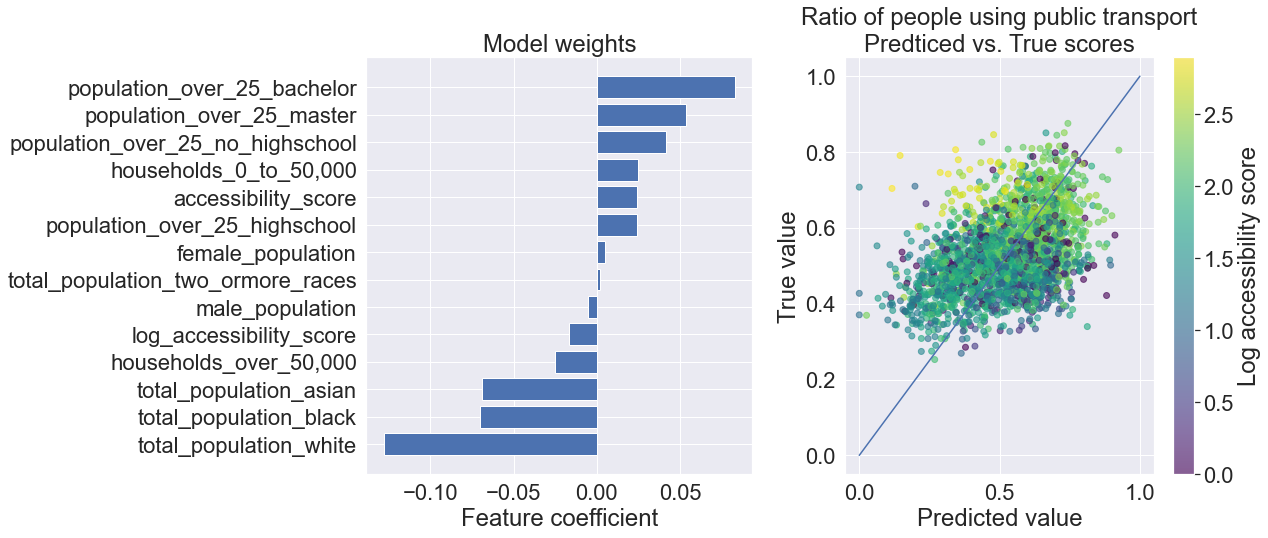

In [42]:
baseline_preds = [np.array(y).mean()]*len(y)
baseline_mse, baseline_r2 = mean_squared_error(y, baseline_preds, squared=False), r2_score(y, baseline_preds)

mse, r2 = mean_squared_error(y, preds, squared=False), r2_score(y, preds)

print(f"MSE:{mse}, Baseline MSE: {baseline_mse}")
print(f"R^2 (coefficient of determination) regression score function.: {r2}, Baseline: {baseline_r2}")


fig, ax = plt.subplots(1,2, figsize=(18,8))
idx = np.argsort(coefs)

ax[0].set_title("Model weights")
ax[0].barh(feature_col[idx],coefs[idx])
ax[0].set_xlabel("Feature coefficient")

points = ax[1].scatter(y, preds, alpha=0.6, c = regression_df[f"log_{accessibility_metric}"], cmap="viridis")
ax[1].set_title("Ratio of people using public transport\nPredticed vs. True scores")
ax[1].plot([x for x in range(2)])
ax[1].set_xlabel("Predicted value")
ax[1].set_ylabel("True value")

plt.colorbar(points,ax=ax[1], label="Log accessibility score")

plt.tight_layout()
plt.savefig("figs/city_modelsum_fewfeatures.png")
plt.show()


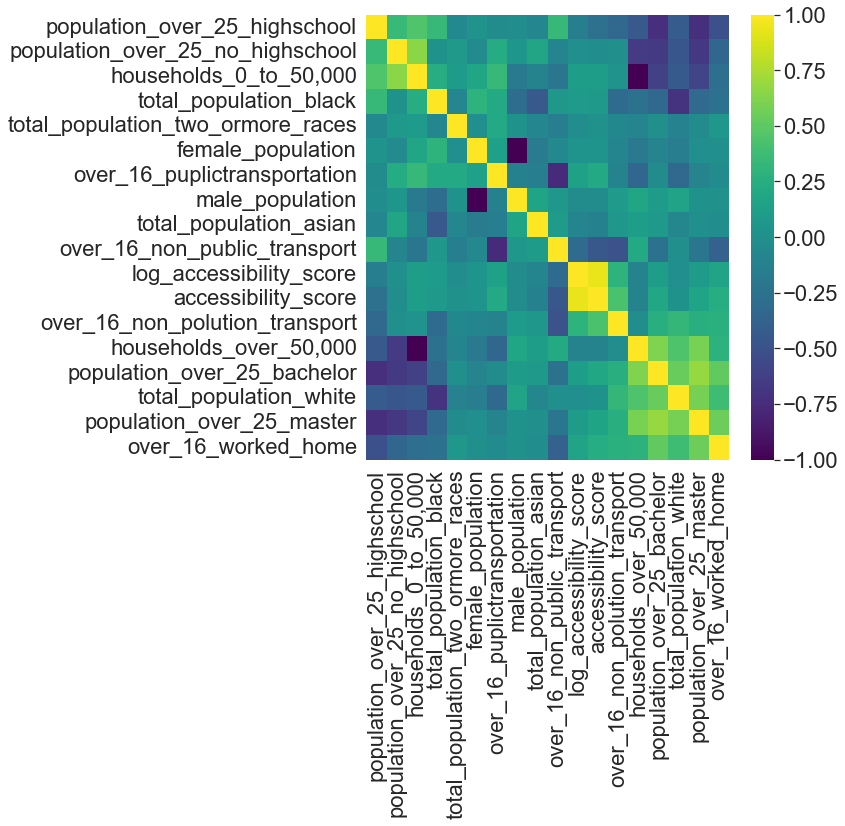

In [43]:
fig, ax = plt.subplots(1, figsize=(12,12))

sns.heatmap(cluster_corr(regression_df[feature_col.tolist() + [target_col, 'over_16_non_public_transport', 'over_16_non_polution_transport', 'over_16_worked_home',]].corr()), cmap="viridis")
plt.tight_layout()
plt.savefig("figs/city_correlations.png")

### Visualizing the results on maps

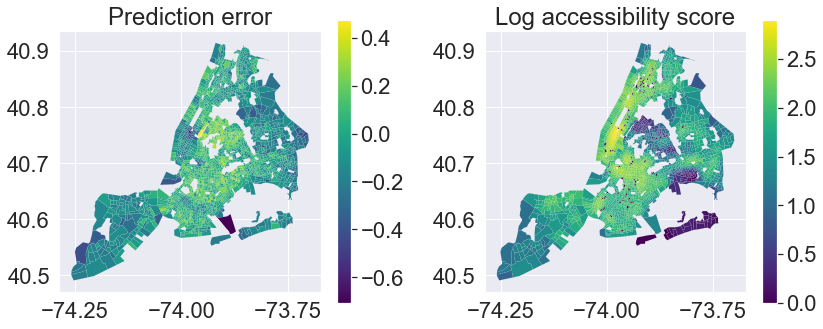

In [44]:
# Visualize Population Density per Census Tract
f, axs = plt.subplots(1,2, figsize=(12,5))

gdf["Prediction_diff"] = y - preds
gdf[f"log_{accessibility_metric}"] = np.log(gdf[f"{accessibility_metric}"]+1)

axs[0] = gdf.plot(column="Prediction_diff",cmap='viridis',alpha=1,linewidth=0.05,ax=axs[0], legend=True)
axs[1] = gdf.plot(column=f"log_{accessibility_metric}",cmap='viridis',alpha=1,linewidth=0.05,ax=axs[1], legend=True)


axs[0].set_title('Prediction error')
axs[1].set_title("Log accessibility score")

plt.tight_layout()
plt.savefig("figs/city_map_res.png")
plt.show()

In [45]:
gdf.to_parquet("city_gdf.parquet")

/var/folders/bx/2b_70g054qg3qt5jhnw30xv40000gn/T/ipykernel_74084/1602231458.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  gdf.to_parquet("city_gdf.parquet")


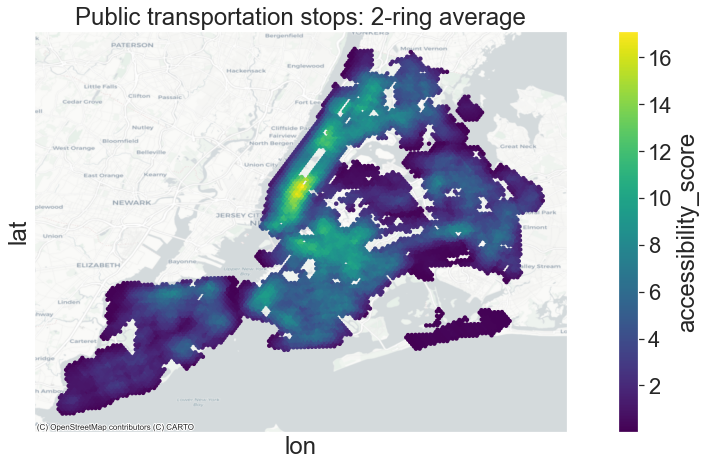

In [46]:
fig, ax = plt.subplots(1, figsize=(4, 7))

# pltot the hexs
gdf[["geometry"]].sjoin(sgdf, how="left").plot.scatter(ax=ax, x='lon', y='lat', c="accessibility_score",
                    edgecolors='none', colormap='viridis', marker='o', figsize=(15,7),)
plt.xticks([], []); plt.yticks([], [])
plt.title('Public transportation stops: 2-ring average');

ctx.add_basemap(ax=ax, crs="EPSG:4326", source=ctx.providers.CartoDB.Positron)
plt.tight_layout()
plt.savefig("figs/stops.png")